# 1. Environment

In [2]:
# Test environment
import torch; print('PyTorch:', torch.__version__, 'CUDA:', torch.cuda.is_available())
if torch.cuda.is_available() :
    print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

PyTorch: 2.4.1+cpu CUDA: False
device : cpu


In [3]:
from matcha.models.matcha_tts import MatchaTTS; print('MatchaTTS OK')
from phonemizer import phonemize; print('Phonemizer OK')

MatchaTTS OK
Phonemizer OK


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as dt
import soundfile as sf

# Import Matcha components
from matcha.models.matcha_tts import MatchaTTS
from matcha.text import text_to_sequence
from matcha.utils.utils import intersperse
from matcha.hifigan.models import Generator as HiFiGAN
from matcha.hifigan.config import v1
from matcha.hifigan.env import AttrDict
from matcha.hifigan.denoiser import Denoiser


# This allows for real time code changes being reflected in the notebook, no need to restart the kernel
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Load Models

In [5]:
# 1. matcha-tts model
MATCHA_CHECKPOINT = r"models\matcha_ljspeech.ckpt"

In [6]:
def load_model(checkpoint_path):
    model = MatchaTTS.load_from_checkpoint(checkpoint_path, map_location=device)
    model.eval()
    return model

model = load_model(MATCHA_CHECKPOINT)
print(f"Model loaded!")

d:\Work Life\Studies\M2 ISI\S1\2 - Machine learning avancé\MLA Projet\MatchaTTS-Implementation-Analysis\.venv\lib\site-packages\lightning\fabric\utilities\cloud_io.py:73: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to 

Model loaded!


In [7]:
# 2. Vocoder (Mel-spectrograms -> Audio)
VOCODER_PATH = r"vocoders\hifigan_T2_v1"

In [8]:
def load_vocoder(checkpoint_path):
    h = AttrDict(v1)
    hifigan = HiFiGAN(h).to(device)
    hifigan.load_state_dict(torch.load(checkpoint_path, map_location=device)['generator'])
    _ = hifigan.eval()
    hifigan.remove_weight_norm()
    return hifigan

vocoder = load_vocoder(VOCODER_PATH)
denoiser = Denoiser(vocoder, mode='zeros')

d:\Work Life\Studies\M2 ISI\S1\2 - Machine learning avancé\MLA Projet\MatchaTTS-Implementation-Analysis\.venv\lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\adjal\AppData\Local\Temp\ipykernel_25156\2714889153.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the

Removing weight norm...


# 3. Run Inference

In [9]:
text_input = "Hello world"

In [10]:
# 1. Text processing

@torch.inference_mode()
def process_text(text, device):
    
    # a. Convert text to phoneme IDs
    # 'english_cleaners2' handles number expansion and phonemization via espeak
    sequence = text_to_sequence(text, ['english_cleaners2'])[0]
    
    # b. Intersperse with '0' (blank token) for the flow matching stability
    sequence = intersperse(sequence, 0)
    
    # c. Convert to tensor
    x = torch.tensor(sequence, dtype=torch.long, device=device)[None] # Add batch dim

    # metadatas
    x_lengths = torch.tensor([x.shape[-1]], dtype=torch.long, device=device)

    # output
    output = {
        'x_orig': text,
        'x': x,
        'x_lengths': x_lengths
    }
    
    return output

In [11]:
processed_text = process_text(text_input, device)
print(f"model input 1 (phonems sequence IDs) : {processed_text['x']}, shape : {processed_text['x'].shape}")
print(f"model input 2 (processed sequence length) : {processed_text['x_lengths']}")

model input 1 (phonems sequence IDs) : tensor([[  0,  50,   0,  83,   0,  54,   0, 156,   0,  57,   0, 135,   0,  16,
           0,  65,   0, 156,   0,  87,   0, 158,   0,  54,   0,  46,   0]]), shape : torch.Size([1, 27])
model input 2 (processed sequence length) : tensor([27])


In [12]:
# 2. run synthesis with model

@torch.inference_mode()
def run_model(
    processed_text, 
    model,
    n_timesteps,
    length_scale,
    temperature,
    spks
    ) :

    """
    output dictionarry : 
        output = {
        "mel": Tensor,
        "mel_lengths": Tensor,
        "wav": Tensor,
        "durations": Tensor,
        "attn": Tensor,
        "noise": Tensor,
        "x_mask": Tensor,
        "y_mask": Tensor,
        "inference_duration": float (s),
        "x": Tensor,
        "x_lengths": Tensor,
        "text": str,
        "phones": list[str],
    }

    """

    # log start
    t_start = dt.datetime.now()

    # start inference
    output = model.synthesise(
        processed_text['x'], 
        processed_text['x_lengths'],
        n_timesteps=n_timesteps,
        length_scale=length_scale,
        temperature=temperature,
        spks=spks
        
    )

    # log end
    t_end = dt.datetime.now()
    inference_duration = (t_end - t_start).total_seconds()

    # merge everything to one dict    
    output.update({'inference_duration': inference_duration, **processed_text})

    # print time
    print(f"Inference completed ! Duration : {inference_duration} s")

    return output

Inference completed ! Duration : 0.25545 s
Generated Mel Shape: torch.Size([1, 80, 80])


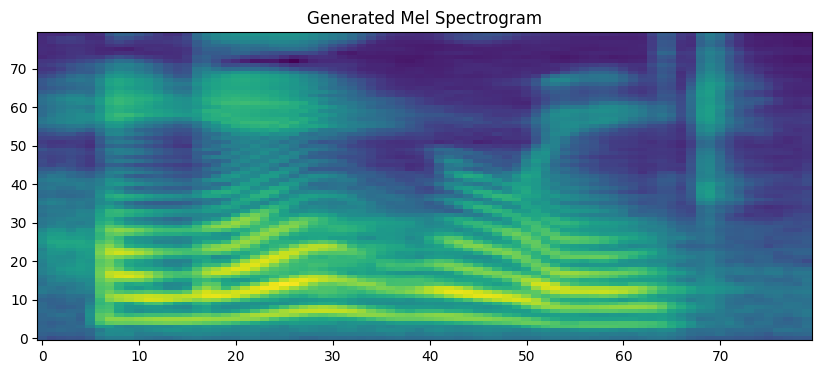

In [13]:
n_timesteps = 10
length_scale = 1
temperature = 0.667
spks = None

output = run_model(
    processed_text, 
    model,
    n_timesteps,
    length_scale,
    temperature,
    spks
    )

mel = output['mel']
print(f"Generated Mel Shape: {mel.shape}")

# Visualisation

plt.figure(figsize=(10, 4))
plt.imshow(mel.squeeze().cpu().numpy(), origin='lower', aspect='auto')
plt.title("Generated Mel Spectrogram")
plt.show()

In [24]:
# 3. Generate audio from mel

@torch.inference_mode()
def to_waveform(mel, vocoder):
    audio = vocoder(mel).clamp(-1, 1)
    audio = denoiser(audio.squeeze(0), strength=0.00025).cpu().squeeze()
    return audio.cpu().squeeze()

def save_to_folder(filename: str, output: dict, folder: str):
    folder = Path(folder)
    folder.mkdir(exist_ok=True, parents=True)
    np.save(folder / f'{filename}', output['mel'].cpu().numpy())
    sf.write(folder / f'{filename}.wav', output['waveform'], 22050, 'PCM_24')
    print(f"Mel and Audio saved in '{folder}'")
    


In [25]:
output['waveform'] = to_waveform(output['mel'], vocoder)

In [26]:
filename = "matchatts_output"
output_folder = "audios"

save_to_folder(filename, output, output_folder)


Mel and Audio saved in 'audios'
